In [12]:
import math
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import PPO_CLASS
from PPO_CLASS import Memory
np.random.seed(1)
tf.set_random_seed(1)


#####################  hyper parameters  ####################

MAX_EPISODES = 2000
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
REPLACEMENT = [
    dict(name='soft', tau=0.01),
    dict(name='hard', rep_iter_a=600, rep_iter_c=500)
][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]

tip=1
tip2=1
snr=-10

for temp in range(1):
    for snr in range(0,4,2):
    #for modulation in range(1):
        var = 10

        # tf.reset_default_graph()
        # sess = tf.Session()

        # with tf.name_scope('S'):
        #     S = tf.placeholder(tf.float32, shape=[None, state_dim], name='s')
        # with tf.name_scope('R'):
        #     R = tf.placeholder(tf.float32, [None, 1], name='r')
        # with tf.name_scope('S_'):
        #     S_ = tf.placeholder(tf.float32, shape=[None, state_dim], name='s_')
        # DDPG_CLASS.S=S
        # DDPG_CLASS.R=R
        # DDPG_CLASS.S_=S_
        # actor = DDPG_CLASS.Actor(sess, action_dim, action_bound, LR_A, REPLACEMENT)
        # critic = DDPG_CLASS.Critic(sess, state_dim, action_dim, LR_C, GAMMA, REPLACEMENT, actor.a, actor.a_)
        # actor.add_grad_to_graph(critic.a_grads)
        
        # M = DDPG_CLASS.Memory(MEMORY_CAPACITY, dims=2 * state_dim + action_dim + 1)
        # sess.run(tf.global_variables_initializer())
        # saver=tf.train.Saver(max_to_keep=100)

        # Initialize actor and critic using PPO_CLASS
        actor = PPO_CLASS.PPOActorCritic(state_dim, action_dim, action_bound, LR_A, LR_C, GAMMA, epsilon)
        
        # Initialize memory
        M = PPO_CLASS.Memory()

        # if OUTPUT_GRAPH:
        #     tf.summary.FileWriter("logs/", sess.graph)
        # Use a checkpoint manager for saving and restoring models
        checkpoint = tf.train.Checkpoint(actor=actor)
        checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory='checkpoints', max_to_keep=100)

        if OUTPUT_GRAPH:
            tf.summary.create_file_writer("logs/")

        print(f"Starting training for SNR: {snr}")

        print("modulation=",modulation,"snr=",snr)

        for i in range(MAX_EPISODES):
    
            s = env.reset_P2P(snr)

            ep_reward = 0
            for j in range(MAX_EP_STEPS):
                a = actor.choose_action(s)
                a = np.random.normal(a, var)
                a=np.clip(a,0,1)
                s_, r, info = env.step_P2P([a,modulation])#input modulation 0:qpsk,1:8psk,2:16qam

                M.store_transition(s, a, r , s_)

                if M.pointer > MEMORY_CAPACITY:
                    #tip and tip2 are only for printing`#
                    if tip == 1:
                        print("memory full",j,i)
                        tip=0
                    var *= 0.9995  # decay the action randomness
                    if tip2 == 1 and var<0.00000001:
                        print("var zero",j,i)
                        tip2=0
                        
                    b_M = M.sample(BATCH_SIZE)
                    b_s = b_M[:, :state_dim]
                    b_a = b_M[:, state_dim: state_dim + action_dim]
                    b_r = b_M[:, -state_dim - 1: -state_dim]
                    b_s_ = b_M[:, -state_dim:]

                    critic.learn(b_s, b_a, b_r, b_s_)
                    actor.learn(b_s)

                s = s_
                
                ep_reward += r


            if i % 30 == 0 :
                print("net bit rate=",r,"action",a, "solar,channel,battery",s,"epoch",i)
                print("ave_reward",ep_reward/(j+1))
                
                
                
        save_path = saver.save(sess, "folder_for_nn_noise"+"/EH_save_net_snr="+str(snr)+str(modulation)+"epoch="+str(i)+"_P2P.ckpt")
        print("Save to path: ", save_path)

print("----------------------------END--------------------------------")

ValueError: `Checkpoint` was expecting a trackable object (an object derived from `Trackable`), got <PPO_CLASS.PPOActorCritic object at 0x35d2ef020>. If you believe this object should be trackable (i.e. it is part of the TensorFlow Python API and manages state), please open an issue.

In [1]:
import math
import tensorflow as tf

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import PPO_CLASS
from PPO_CLASS import Memory
np.random.seed(1)
#tf.set_random_seed(1)
tf.random.set_seed(1)

#####################  hyper parameters  ####################

MAX_EPISODES = 500
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
# REPLACEMENT = [
#     dict(name='soft', tau=0.01),
#     dict(name='hard', rep_iter_a=600, rep_iter_c=500)
# ][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]
epsilon=0.2
Modulation_type = 0  # Set to a valid modulation type (e.g., 0 for QPSK, 1 for 8PSK)
episodeList = []
netBitRate = []
ave_reward = []

tip=1
tip2=1
#snr=-10

def save_weights(actor, episode, snr):
    # Update file paths to end with `.weights.h5`
    actor.actor_model.save_weights(f"checkpoints/actor_weights_SNR={snr}_Episode={episode}.weights.h5")
    actor.critic_model.save_weights(f"checkpoints/critic_weights_SNR={snr}_Episode={episode}.weights.h5")
    print(f"Weights saved for snr {snr} episode {episode}.")

def load_weights(actor, episode):
    # Update file paths to match the updated save path
    actor.actor_model.load_weights(f"checkpoints/actor_weights_SNR={snr}_Episode={episode}.weights.h5")
    actor.critic_model.load_weights(f"ccheckpoints/critic_weights_SNR={snr}_Episode={episode}.weights.h5")
    print(f"Weights loaded for snr {snr} episode {episode}.")

print("Starting PPO training...")

# Training loop
for snr in range(0, 2, 2):

    # Reset TensorFlow after each SNR value
    tf.keras.backend.clear_session()  # Clear the session to reset TensorFlow state
    print(f"Training started for SNR: {snr}")

    # Initialize PPO components
    actor = PPO_CLASS.PPOActorCritic(state_dim, action_dim, action_bound, LR_A, LR_C, GAMMA, epsilon)
    memory = PPO_CLASS.Memory()
    var = 10

    for episode in range(MAX_EPISODES):
        s = env.reset_P2P(snr)
        s = (s - np.mean(s)) / (np.std(s) + 1e-8)  # Normalize initial state
        ep_reward = 0
        
        for step in range(MAX_EP_STEPS):
            s_array = np.array(s, dtype=np.float32).reshape(1, state_dim)

            # Get action and log probability
            a, log_prob = actor.get_action_and_log_prob(s_array)
            #a = np.clip(a, 0, 1)
            a = np.clip(a, 0, 1) * action_bound

            # Get value
            value = actor.get_value(s_array)

            # Step the environment with both action and modulation type
            #s_, r, info = env.step_P2P([a[0], Modulation_type])  # Ensure the input is a list of two elements
            s_, r, info = env.step_P2P([a[0], Modulation_type])
            #r /= 100  # Normalize reward for stability
            s_ = (s_ - np.mean(s_)) / (np.std(s_) + 1e-8)  # Normalize the new state
            memory.store(s, a, r, value[0], log_prob[0])

            s = s_
            ep_reward += r


        # Compute advantages and target values
        advantages, target_values = memory.compute_advantages_and_targets(GAMMA, 0.95)

        # Train the actor-critic
        actor.update(
            np.array(memory.states),
            np.array(memory.actions),
            advantages[:, None],
            target_values[:, None],
            np.array(memory.log_probs)[:, None]
        )
        memory.clear()

        # Logging every 30 episodes
        if episode % 30 == 0:
            print(f"Net bit rate: {r:.2f}, Action: {a.flatten()}, [Solar: {s[2]:.2f}, Channel: {s[1]:.2f}, Battery: {s[0]:.2f}], Epoch: {episode}")
            print(f"Average Reward: {ep_reward / MAX_EP_STEPS:.2f}")

            episodeList.append(episode)
            netBitRate.append(r)
            ave_reward.append(ep_reward / MAX_EP_STEPS)
        
        # Save weights periodically
        if episode == 499:
            save_weights(actor, episode, snr)
    
    print(f"Training complete for SNR: {snr}")

print("----------------------------END--------------------------------")

Starting PPO training...
Training started for SNR: 0
Net bit rate: 0.00, Action: [0.], [Solar: 0.03, Channel: 1.21, Battery: -1.24], Epoch: 0
Average Reward: 84488.95
Net bit rate: 200000.00, Action: [0.27841535], [Solar: 0.34, Channel: 1.02, Battery: -1.36], Epoch: 30
Average Reward: 91211.49
Net bit rate: 193186.84, Action: [0.14738576], [Solar: -0.02, Channel: 1.24, Battery: -1.21], Epoch: 60
Average Reward: 107213.77
Net bit rate: 0.00, Action: [0.01980481], [Solar: 0.55, Channel: 0.85, Battery: -1.40], Epoch: 90
Average Reward: 110516.71
Net bit rate: 199999.90, Action: [0.23993781], [Solar: 0.10, Channel: 1.17, Battery: -1.27], Epoch: 120
Average Reward: 126023.03
Net bit rate: 199990.87, Action: [0.15479551], [Solar: 0.30, Channel: 1.04, Battery: -1.35], Epoch: 150
Average Reward: 130701.63
Net bit rate: 200000.00, Action: [0.28839928], [Solar: 0.16, Channel: 1.13, Battery: -1.30], Epoch: 180
Average Reward: 129433.59
Net bit rate: 200000.00, Action: [0.2826625], [Solar: 0.16, C

In [3]:
netBitRate

[0.0,
 199999.99999991118,
 193186.84407438178,
 4.8814202172829366e-11,
 199999.90024688578,
 199990.87172953144,
 199999.99997348787,
 199999.99992752465,
 199999.99681463695,
 199999.99684923148,
 199999.99138426982,
 199999.97103663706,
 199999.96286433112,
 199999.9735166529,
 199999.9858042004,
 199999.99327777734,
 199999.99663633513]

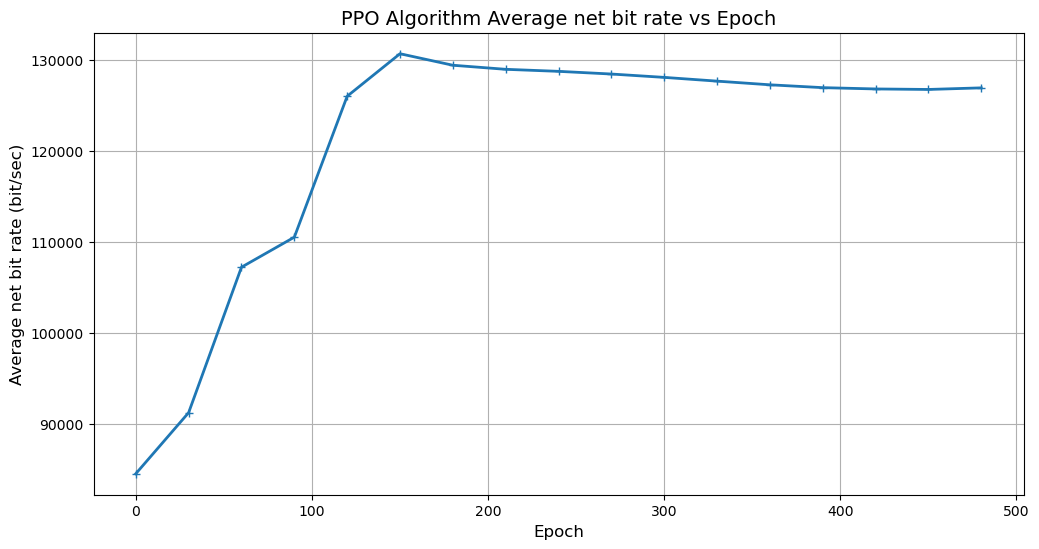

In [9]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(episodeList, ave_reward, marker='+', linestyle='-', linewidth=2)

# Add labels and title
plt.title('PPO Algorithm Average net bit rate vs Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average net bit rate (bit/sec)', fontsize=12)

# Add grid for better visualization
plt.grid(True)

# Save the plot
plt.savefig('PPO Algorithm Training P2P net_bit_rate vs epochs.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

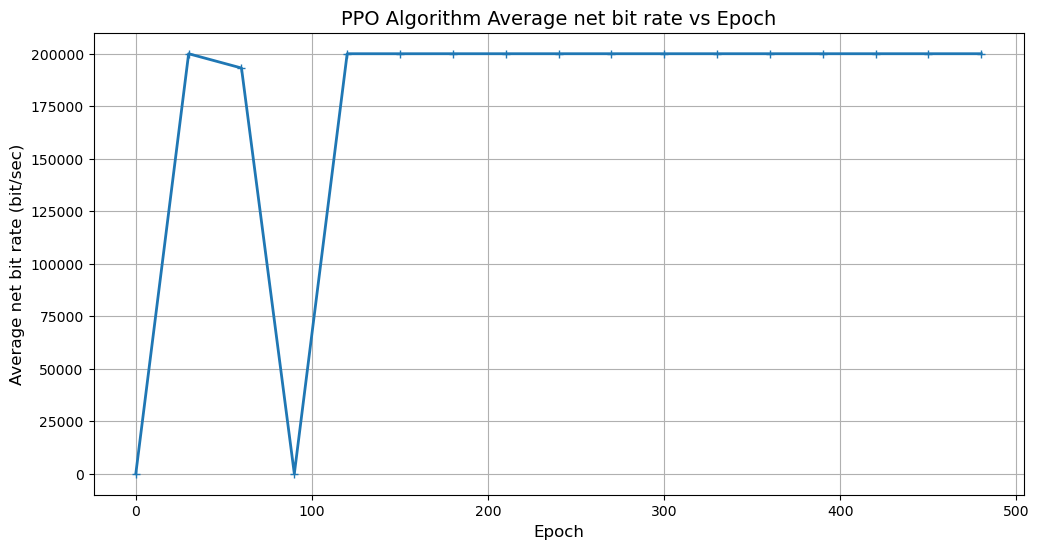

In [8]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(episodeList, netBitRate, marker='+', linestyle='-', linewidth=2)

# Add labels and title
plt.title('PPO Algorithm Average net bit rate vs Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average net bit rate (bit/sec)', fontsize=12)

# Add grid for better visualization
plt.grid(True)

# Save the plot
plt.savefig('PPO Algorithm Training P2P average_reward_vs_epochs.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [10]:
import math
import tensorflow as tf

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import PPO_CLASS
from PPO_CLASS import Memory
np.random.seed(1)
#tf.set_random_seed(1)
tf.random.set_seed(1)

#####################  hyper parameters  ####################

MAX_EPISODES = 500
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
# REPLACEMENT = [
#     dict(name='soft', tau=0.01),
#     dict(name='hard', rep_iter_a=600, rep_iter_c=500)
# ][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]
epsilon=0.2
Modulation_type = 0  # Set to a valid modulation type (e.g., 0 for QPSK, 1 for 8PSK)
new_episodeList = []
new_netBitRate = []
new_ave_reward = []

tip=1
tip2=1
#snr=-10

def save_weights(actor, episode, snr):
    # Update file paths to end with `.weights.h5`
    actor.actor_model.save_weights(f"checkpoints/actor_weights_SNR={snr}_Episode={episode}.weights.h5")
    actor.critic_model.save_weights(f"checkpoints/critic_weights_SNR={snr}_Episode={episode}.weights.h5")
    print(f"Weights saved for snr {snr} episode {episode}.")

def load_weights(actor, episode):
    # Update file paths to match the updated save path
    actor.actor_model.load_weights(f"checkpoints/actor_weights_SNR={snr}_Episode={episode}.weights.h5")
    actor.critic_model.load_weights(f"ccheckpoints/critic_weights_SNR={snr}_Episode={episode}.weights.h5")
    print(f"Weights loaded for snr {snr} episode {episode}.")

print("Starting PPO training...")

# Training loop
for snr in range(0, 12, 2):

    # Reset TensorFlow after each SNR value
    tf.keras.backend.clear_session()  # Clear the session to reset TensorFlow state
    print(f"Training started for SNR: {snr}")

    # Initialize PPO components
    actor = PPO_CLASS.PPOActorCritic(state_dim, action_dim, action_bound, LR_A, LR_C, GAMMA, epsilon)
    memory = PPO_CLASS.Memory()
    var = 10

    for episode in range(MAX_EPISODES):
        s = env.reset_P2P(snr)
        s = (s - np.mean(s)) / (np.std(s) + 1e-8)  # Normalize initial state
        ep_reward = 0
        
        for step in range(MAX_EP_STEPS):
            s_array = np.array(s, dtype=np.float32).reshape(1, state_dim)

            # Get action and log probability
            a, log_prob = actor.get_action_and_log_prob(s_array)
            #a = np.clip(a, 0, 1)
            a = np.clip(a, 0, 1) * action_bound

            # Get value
            value = actor.get_value(s_array)

            # Step the environment with both action and modulation type
            #s_, r, info = env.step_P2P([a[0], Modulation_type])  # Ensure the input is a list of two elements
            s_, r, info = env.step_P2P([a[0], Modulation_type])
            #r /= 100  # Normalize reward for stability
            s_ = (s_ - np.mean(s_)) / (np.std(s_) + 1e-8)  # Normalize the new state
            memory.store(s, a, r, value[0], log_prob[0])

            s = s_
            ep_reward += r


        # Compute advantages and target values
        advantages, target_values = memory.compute_advantages_and_targets(GAMMA, 0.95)

        # Train the actor-critic
        actor.update(
            np.array(memory.states),
            np.array(memory.actions),
            advantages[:, None],
            target_values[:, None],
            np.array(memory.log_probs)[:, None]
        )
        memory.clear()

        # Logging every 30 episodes
        if episode % 30 == 0:
            print(f"Net bit rate: {r:.2f}, Action: {a.flatten()}, [Solar: {s[2]:.2f}, Channel: {s[1]:.2f}, Battery: {s[0]:.2f}], Epoch: {episode}")
            print(f"Average Reward: {ep_reward / MAX_EP_STEPS:.2f}")

            new_episodeList.append(episode)
            new_netBitRate.append(r)
            new_ave_reward.append(ep_reward / MAX_EP_STEPS)
        
        # Save weights periodically
        if episode == 499:
            save_weights(actor, episode, snr)
    
    print(f"Training complete for SNR: {snr}")

print("----------------------------END--------------------------------")

Starting PPO training...
Training started for SNR: 0
Net bit rate: 0.00, Action: [0.], [Solar: 0.03, Channel: 1.21, Battery: -1.24], Epoch: 0
Average Reward: 54356.87
Net bit rate: 0.00, Action: [0.], [Solar: 1.21, Channel: 0.02, Battery: -1.24], Epoch: 30
Average Reward: 48707.64
Net bit rate: 0.00, Action: [0.02246358], [Solar: 0.07, Channel: 1.19, Battery: -1.26], Epoch: 60
Average Reward: 66417.93
Net bit rate: 0.00, Action: [0.], [Solar: 1.22, Channel: 0.01, Battery: -1.23], Epoch: 90
Average Reward: 73389.69
Net bit rate: 199999.99, Action: [0.10761931], [Solar: 0.96, Channel: 0.43, Battery: -1.38], Epoch: 120
Average Reward: 93601.86
Net bit rate: 199873.51, Action: [0.04412147], [Solar: 1.20, Channel: 0.05, Battery: -1.25], Epoch: 150
Average Reward: 105741.14
Net bit rate: 200000.00, Action: [0.05940608], [Solar: 1.36, Channel: -0.34, Battery: -1.02], Epoch: 180
Average Reward: 56836.67
Net bit rate: 188541.46, Action: [0.01403159], [Solar: 1.36, Channel: -0.36, Battery: -1.00

In [1]:
import math
import tensorflow as tf

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

import numpy as np
import gym
import time
import EH_P2P
import PPO_CLASS
from PPO_CLASS import Memory
np.random.seed(1)
#tf.set_random_seed(1)
tf.random.set_seed(1)

#####################  hyper parameters  ####################

MAX_EPISODES = 500
MAX_EP_STEPS = 120
LR_A = 0.0002   # learning rate for actor
LR_C = 0.0002  # learning rate for critic
GAMMA = 0.999    # reward discount
# REPLACEMENT = [
#     dict(name='soft', tau=0.01),
#     dict(name='hard', rep_iter_a=600, rep_iter_c=500)
# ][0]            # you can try different target replacement strategies
MEMORY_CAPACITY = 40000
BATCH_SIZE = 80

OUTPUT_GRAPH = False
    
env=EH_P2P.EH_P2P()
env.Chanpower()
env.Solarread()
    
state_dim = 3 #channel,battery，solar
action_dim = 1 #Transmission power
action_bound = 1 #[0,1]
epsilon=0.2
Modulation_type = 0  # Set to a valid modulation type (e.g., 0 for QPSK, 1 for 8PSK)
new_episodeList = []
new_netBitRate = []
new_ave_reward = []

tip=1
tip2=1
#snr=-10

def save_weights(actor, episode, snr):
    # Update file paths to end with `.weights.h5`
    actor.actor_model.save_weights(f"checkpoints/actor_weights_SNR={snr}_Episode={episode}.weights.h5")
    actor.critic_model.save_weights(f"checkpoints/critic_weights_SNR={snr}_Episode={episode}.weights.h5")
    print(f"Weights saved for snr {snr} episode {episode}.")

def load_weights(actor, episode):
    # Update file paths to match the updated save path
    actor.actor_model.load_weights(f"checkpoints/actor_weights_SNR={snr}_Episode={episode}.weights.h5")
    actor.critic_model.load_weights(f"ccheckpoints/critic_weights_SNR={snr}_Episode={episode}.weights.h5")
    print(f"Weights loaded for snr {snr} episode {episode}.")

print("Starting PPO training...")

# Training loop
for snr in range(10, 12, 2):

    # Reset TensorFlow after each SNR value
    tf.keras.backend.clear_session()  # Clear the session to reset TensorFlow state
    print(f"Training started for SNR: {snr}")

    # Initialize PPO components
    actor = PPO_CLASS.PPOActorCritic(state_dim, action_dim, action_bound, LR_A, LR_C, GAMMA, epsilon)
    memory = PPO_CLASS.Memory()
    var = 10

    for episode in range(MAX_EPISODES):
        s = env.reset_P2P(snr)
        s = (s - np.mean(s)) / (np.std(s) + 1e-8)  # Normalize initial state
        ep_reward = 0
        
        for step in range(MAX_EP_STEPS):
            s_array = np.array(s, dtype=np.float32).reshape(1, state_dim)

            # Get action and log probability
            a, log_prob = actor.get_action_and_log_prob(s_array)
            #a = np.clip(a, 0, 1)
            a = np.clip(a, 0, 1) * action_bound

            # Get value
            value = actor.get_value(s_array)

            # Step the environment with both action and modulation type
            #s_, r, info = env.step_P2P([a[0], Modulation_type])  # Ensure the input is a list of two elements
            s_, r, info = env.step_P2P([a[0], Modulation_type])
            #r /= 100  # Normalize reward for stability
            s_ = (s_ - np.mean(s_)) / (np.std(s_) + 1e-8)  # Normalize the new state
            memory.store(s, a, r, value[0], log_prob[0])

            s = s_
            ep_reward += r


        # Compute advantages and target values
        advantages, target_values = memory.compute_advantages_and_targets(GAMMA, 0.95)

        # Train the actor-critic
        actor.update(
            np.array(memory.states),
            np.array(memory.actions),
            advantages[:, None],
            target_values[:, None],
            np.array(memory.log_probs)[:, None]
        )
        memory.clear()

        # Logging every 30 episodes
        if episode % 30 == 0:
            print(f"Net bit rate: {r:.2f}, Action: {a.flatten()}, [Solar: {s[2]:.2f}, Channel: {s[1]:.2f}, Battery: {s[0]:.2f}], Epoch: {episode}")
            print(f"Average Reward: {ep_reward / MAX_EP_STEPS:.2f}")

            #new_episodeList.append(episode)
            #new_netBitRate.append(r)
            #new_ave_reward.append(ep_reward / MAX_EP_STEPS)
        
        # Save weights periodically
        if episode == 499:
            save_weights(actor, episode, snr)
    
    print(f"Training complete for SNR: {snr}")

print("----------------------------END--------------------------------")

Starting PPO training...
Training started for SNR: 10
Net bit rate: 0.00, Action: [0.], [Solar: 0.03, Channel: 1.21, Battery: -1.24], Epoch: 0
Average Reward: 102530.15
Net bit rate: 200000.00, Action: [0.24469362], [Solar: 0.44, Channel: 0.95, Battery: -1.38], Epoch: 30
Average Reward: 128766.40
Net bit rate: 200000.00, Action: [0.1255688], [Solar: -0.03, Channel: 1.24, Battery: -1.21], Epoch: 60
Average Reward: 160509.97
Net bit rate: 200000.00, Action: [0.12009799], [Solar: 0.35, Channel: 1.01, Battery: -1.36], Epoch: 90
Average Reward: 185768.25
Net bit rate: 200000.00, Action: [0.36645275], [Solar: -0.13, Channel: 1.28, Battery: -1.16], Epoch: 120
Average Reward: 189446.20
Net bit rate: 200000.00, Action: [0.35774857], [Solar: -0.11, Channel: 1.28, Battery: -1.17], Epoch: 150
Average Reward: 190008.30
Net bit rate: 200000.00, Action: [0.5828238], [Solar: -0.29, Channel: 1.35, Battery: -1.05], Epoch: 180
Average Reward: 190117.86
Net bit rate: 200000.00, Action: [0.678134], [Solar: